# Simple Toy TS Training for Deep3D+

In [1]:
"""
Simple tester for the deep3d
"""
import tensorflow as tf
import Deep3D_branched as deep3d
import utils
import numpy as np
import os
import os.path
import h5py

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Importing Data from H5 Format for fast loading
- Will eventually unit test dynamic CPU data loading pipeline here

In [2]:
inria_file = '/a/data/deep3d_data/inria_data.h5'
# inria_file = 'data/inria_data.h5'
h5f = h5py.File(inria_file,'r')

X_train_0 = h5f['X_0'][:,10:170,16:304,:]
Y_train_0 = h5f['Y_0'][:,10:170,16:304,:]
X_train_1 = h5f['X_1'][:,10:170,16:304,:]
Y_train_1 = h5f['Y_1'][:,10:170,16:304,:]
X_train_2 = h5f['X_2'][:,10:170,16:304,:]
Y_train_2 = h5f['Y_2'][:,10:170,16:304,:]
X_train_3 = h5f['X_3'][:,10:170,16:304,:]
Y_train_3 = h5f['Y_3'][:,10:170,16:304,:]
X_train_4 = h5f['X_4'][:,10:170,16:304,:]
Y_train_4 = h5f['Y_4'][:,10:170,16:304,:]
X_train_5 = h5f['X_5'][:,10:170,16:304,:]
Y_train_5 = h5f['Y_5'][:,10:170,16:304,:]
X_train_6 = h5f['X_6'][:,10:170,16:304,:]
Y_train_6 = h5f['Y_6'][:,10:170,16:304,:]
#X_train_7 = h5f['X_7'][:,10:170,16:304,:]
#Y_train_7 = h5f['Y_7'][:,10:170,16:304,:]


X_val = h5f['X_7'][:,10:170,16:304,:]
Y_val = h5f['Y_7'][:,10:170,16:304,:]
  
h5f.close()



# ------------------------------------------#
X_train = np.concatenate([X_train_0,X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6])
Y_train = np.concatenate([Y_train_0,Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5,Y_train_6])

print "Training Size:" + str(X_train.shape)
print "Validation Size:" + str(X_val.shape)

Training Size:(3500, 160, 288, 3)
Validation Size:(443, 160, 288, 3)


## Training Loop

In [3]:
batchsize = 50
num_epochs = 5
num_batches = (X_train.shape[0]/batchsize)*num_epochs
#num_batches = 20
print_step = 1
viz_step = 10

# Define config for GPU memory debugging 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # Switch to True for dynamic memory allocation instead of TF hogging BS
config.gpu_options.per_process_gpu_memory_fraction= 1  # Cap TF mem usage
config.allow_soft_placement=True
with tf.device('/gpu:0'):
    # Session
    sess = tf.Session(config=config)
    
    # Placeholders
    images = tf.placeholder(tf.float32, [None, 160, 288, 3], name='input_batch')
    true_out = tf.placeholder(tf.float32, [None, 160, 288, 3] , name='ground_truth')
    train_mode = tf.placeholder(tf.bool, name='train_mode')

    # Building Net based on VGG weights 
    net = deep3d.Deep3Dnet('./vgg19.npy', dropout = 0.5)
    net.build(images, train_mode)

    # Print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print 'Variable count:'
    print(net.get_var_count())
    
    # Run initializer 
    sess.run(tf.global_variables_initializer())
   
    # Define Training Objectives
    with tf.variable_scope("Loss"):
        #reg_factor = 1e-5
        cost = tf.reduce_sum(tf.abs(net.prob - true_out))/batchsize
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):    
        train = tf.train.GradientDescentOptimizer(0.00005).minimize(cost)
        
    # Track Cost    
    tf.summary.scalar('cost', cost)
    # tensorboard operations to compile summary and then write into logs
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./tensorboard_logs/', graph = sess.graph)

    
    # Training Loop
    print ""
    print "== Start training =="
    for i in xrange(num_batches):
        # Creating Batch
        image_mask = np.random.choice(X_train.shape[0],batchsize)
        images_in = X_train[image_mask,:,:,:]
        labels_in = Y_train[image_mask,:,:,:]

        # Traing Step
        _, cost_val, summary = sess.run([train, cost, merged], feed_dict={images: images_in, true_out: labels_in, train_mode: True})
        writer.add_summary(summary, i)

        # No longer needed: cost_hist.append(cost_val)
        if i%print_step == 0:
            print ("({}/{})".format(i, num_batches).ljust(10) + ' | Cost: ' + str(cost_val))
    
    
    print ""
    print "Training Completed, storing weights"
    # Store Traing Output
    net.save_npy(sess)
    

Variable count:
139063583

== Start training ==
(0/350)    | Cost: 12354.6
(1/350)    | Cost: 8932.54
(2/350)    | Cost: 7737.78
(3/350)    | Cost: 7859.61
(4/350)    | Cost: 7655.26
(5/350)    | Cost: 7603.38
(6/350)    | Cost: 8380.16
(7/350)    | Cost: 6846.65
(8/350)    | Cost: 7917.31
(9/350)    | Cost: 8290.65
(10/350)   | Cost: 7344.82
(11/350)   | Cost: 8182.17
(12/350)   | Cost: 8324.96
(13/350)   | Cost: 7419.15
(14/350)   | Cost: 6340.33
(15/350)   | Cost: 7292.87
(16/350)   | Cost: 7154.63
(17/350)   | Cost: 7376.77
(18/350)   | Cost: 8616.3
(19/350)   | Cost: 7454.2
(20/350)   | Cost: 8802.47
(21/350)   | Cost: 6881.51
(22/350)   | Cost: 7993.93
(23/350)   | Cost: 7522.73
(24/350)   | Cost: 8086.38
(25/350)   | Cost: 6884.76
(26/350)   | Cost: 7069.85
(27/350)   | Cost: 6868.42
(28/350)   | Cost: 7016.32
(29/350)   | Cost: 7136.2
(30/350)   | Cost: 8281.02
(31/350)   | Cost: 8359.61
(32/350)   | Cost: 7504.79
(33/350)   | Cost: 6897.28
(34/350)   | Cost: 8980.52
(35/350)  

(303/350)  | Cost: 6328.73
(304/350)  | Cost: 7064.97
(305/350)  | Cost: 7031.31
(306/350)  | Cost: 6211.97
(307/350)  | Cost: 6508.57
(308/350)  | Cost: 6525.75
(309/350)  | Cost: 7104.55
(310/350)  | Cost: 6391.02
(311/350)  | Cost: 6440.73
(312/350)  | Cost: 7085.99
(313/350)  | Cost: 7257.04
(314/350)  | Cost: 5993.82
(315/350)  | Cost: 6984.09
(316/350)  | Cost: 7125.72
(317/350)  | Cost: 6352.92
(318/350)  | Cost: 6569.53
(319/350)  | Cost: 6429.34
(320/350)  | Cost: 6162.26
(321/350)  | Cost: 6573.39
(322/350)  | Cost: 6214.51
(323/350)  | Cost: 6040.15
(324/350)  | Cost: 6453.95
(325/350)  | Cost: 6293.22
(326/350)  | Cost: 5898.29
(327/350)  | Cost: 6359.42
(328/350)  | Cost: 6683.31
(329/350)  | Cost: 7000.84
(330/350)  | Cost: 6547.42
(331/350)  | Cost: 6934.67
(332/350)  | Cost: 6237.87
(333/350)  | Cost: 6089.34
(334/350)  | Cost: 6466.7
(335/350)  | Cost: 6564.87
(336/350)  | Cost: 6871.94
(337/350)  | Cost: 6294.39
(338/350)  | Cost: 6182.48
(339/350)  | Cost: 6705.71
(3

## Testing Output

In [13]:
# Test
test_img = np.expand_dims(X_val[175], axis = 0)
test_ans = Y_val[175]

with tf.device("/gpu:0"):
    res, mask, up_conv = sess.run([net.prob, net.mask, net.up_conv], 
                                  feed_dict={images: test_img, train_mode: False})

--- Input ---


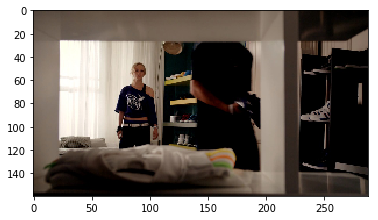

--- GT ---


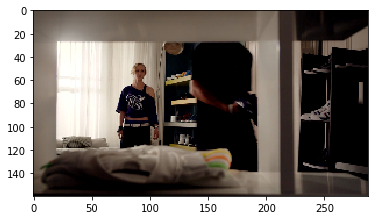

--- Our result ---


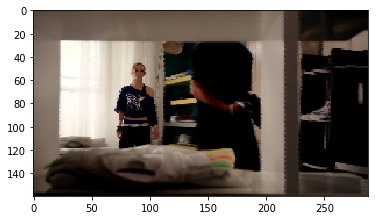

In [14]:
import matplotlib.pyplot as plt
print "--- Input ---"
plt.imshow(test_img[0])
plt.show()

print "--- GT ---"
plt.imshow(test_ans)
plt.show()

print "--- Our result ---"
plt.imshow(res[0])
plt.show()

#pyplot.imsave('1.jpeg', test_img[0])
#pyplot.imsave('2.jpeg', res[0])

## Looking at Disparity Maps

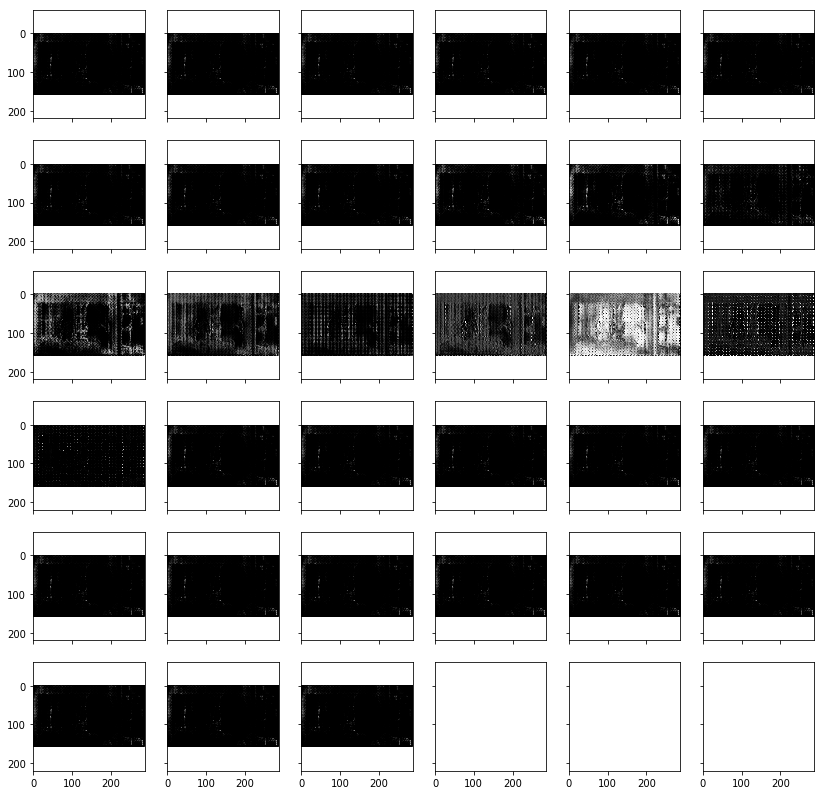

In [15]:
f, axs = plt.subplots(6, 6, sharex='col', sharey='row',figsize=(14,14))

for i in range(33):
    axs[i/6][i%6].imshow(mask[0,:,:,i],cmap="gray")
plt.show()

In [16]:
max_shift_channel = np.argmax(mask,axis = 3)
max_shift_channel[0]

array([[17, 15, 17, ..., 15, 15, 14],
       [17, 16, 16, ..., 16, 14, 15],
       [17, 16, 17, ..., 16, 15, 15],
       ..., 
       [17, 16, 16, ..., 16, 14, 15],
       [17, 15, 17, ..., 15, 14, 13],
       [15, 15, 17, ..., 15, 13, 13]])

In [17]:
channel_mean = np.mean(mask[0], axis =(0,1))
channel_mean

array([  2.85481219e-04,   2.85481219e-04,   2.85488495e-04,
         2.85481219e-04,   2.85481918e-04,   2.85510207e-04,
         2.85495480e-04,   2.85481219e-04,   3.08084709e-04,
         5.83225628e-04,   9.54306859e-04,   5.30300848e-03,
         1.42243002e-02,   4.40394692e-02,   7.23295882e-02,
         1.64956361e-01,   5.64467490e-01,   1.11809596e-01,
         1.46712922e-02,   3.46704503e-04,   2.90783530e-04,
         2.85746530e-04,   2.85591930e-04,   2.85509450e-04,
         2.85506772e-04,   2.85496615e-04,   2.85481277e-04,
         2.85486516e-04,   2.85481219e-04,   2.85481219e-04,
         2.85481219e-04,   2.85481219e-04,   2.85481219e-04], dtype=float32)

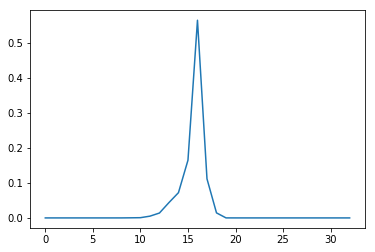

In [18]:
plt.plot(channel_mean)
plt.show()

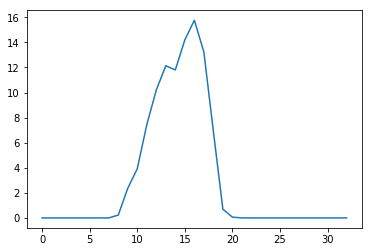

In [19]:
channel_act_mean = np.mean(up_conv[0], axis =(0,1))
plt.plot(channel_act_mean)
plt.show()

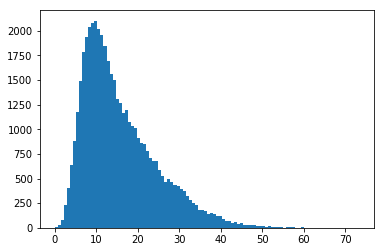

In [20]:
plt.hist(up_conv[0,:,:,16].ravel(), bins=100)
plt.show()

0


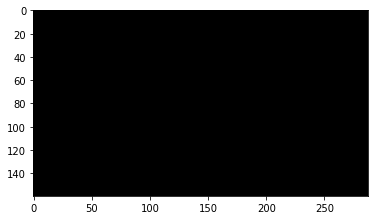

1


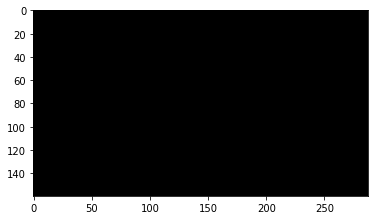

2


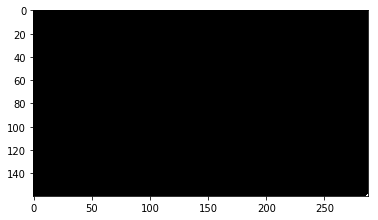

3


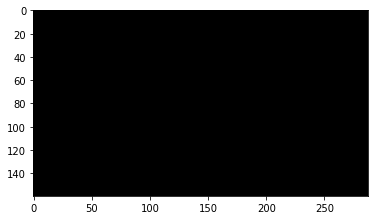

4


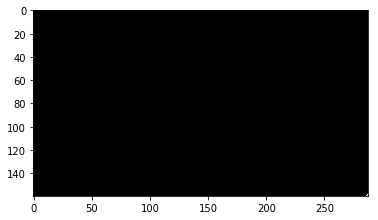

5


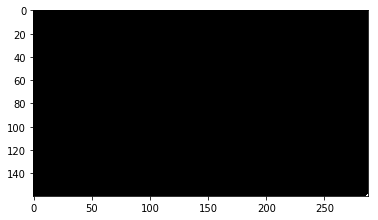

6


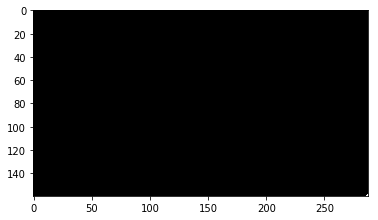

7


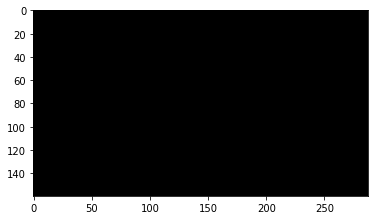

8


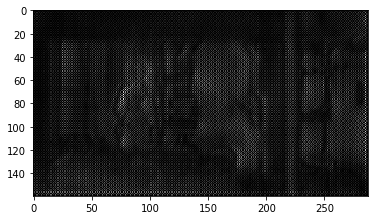

9


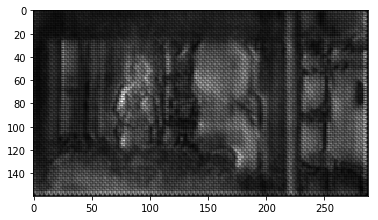

10


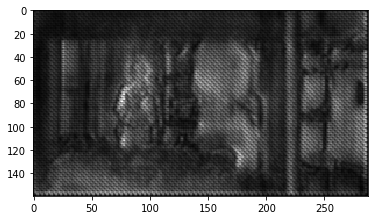

11


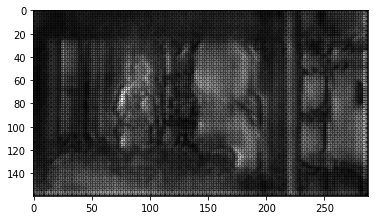

12


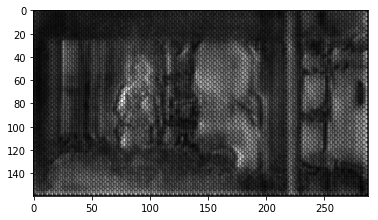

13


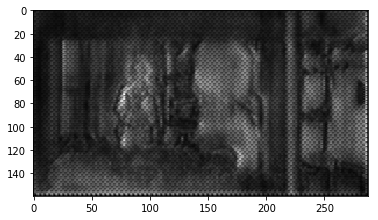

14


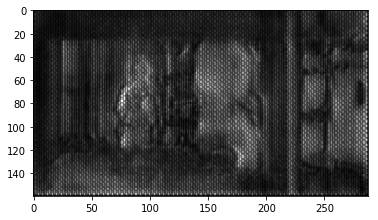

15


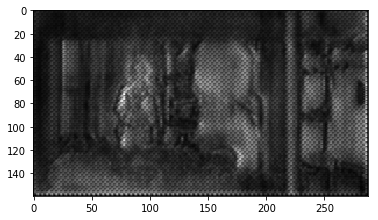

16


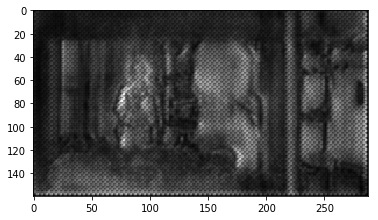

17


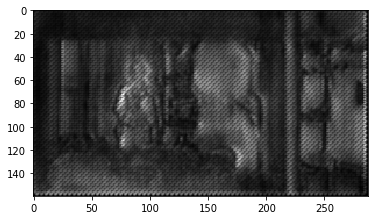

18


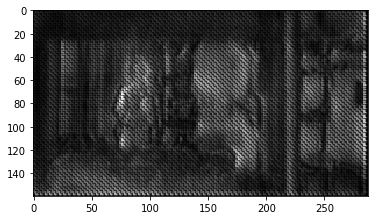

19


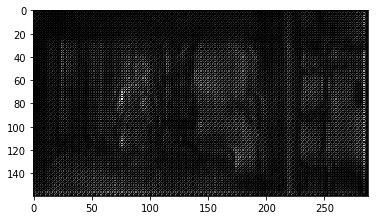

20


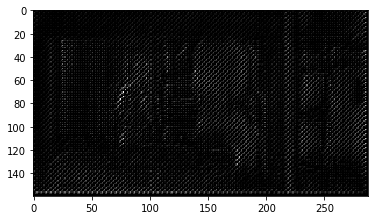

21


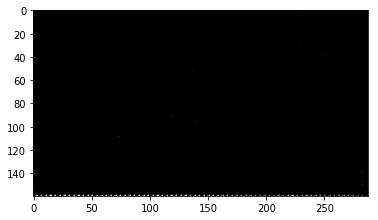

22


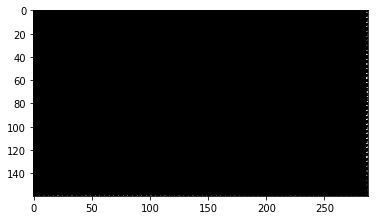

23


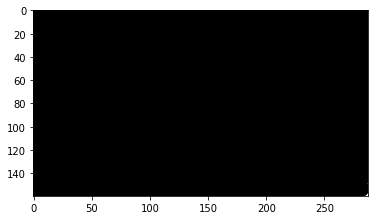

24


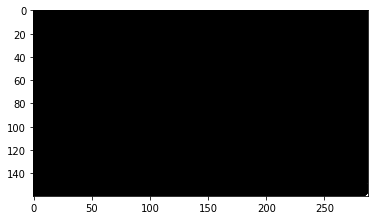

25


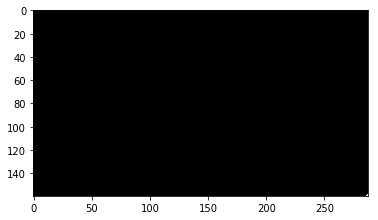

26


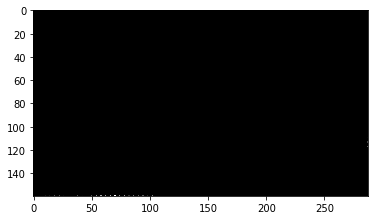

27


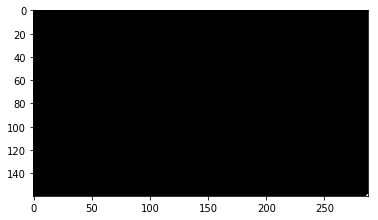

28


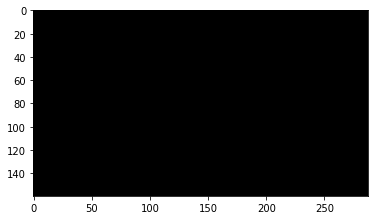

29


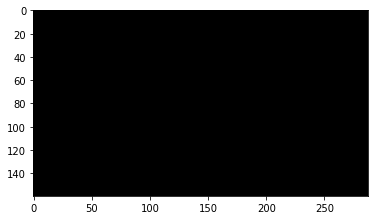

30


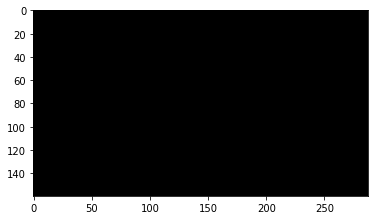

31


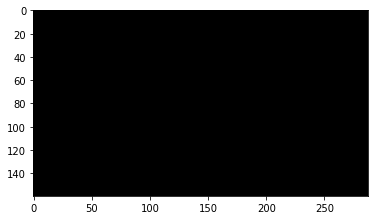

32


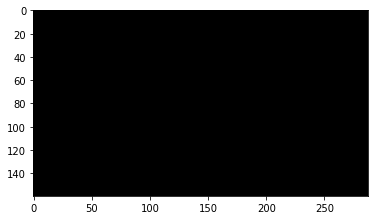

In [21]:
for layer in range(33):
    print layer
    plt.imshow(up_conv[0,:,:,layer], cmap="gray")
    plt.show()